# Solution for Homework 5

In [1]:
# Boilerplate instructions for importing NumPy and Matplotlib
# Import NumPy
import numpy as np

# To plot pretty figures, use matplotlib
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)


### Import Code from Notebooks

In [2]:
def random_symbols(A, N):
    """generate random symbols from the constallation A
    
    Inputs:
    A - np.ndarray of symbols in constellation, e.g., A = np.array([1, -1]) for BPSK
    N - number of random symbols to produce

    Returns:
    Numpy array of length N
    """
    return A[np.random.randint(len(A), size=N)]

In [3]:
def srrc_pulse(a, fsT, N=5):
    """Construct a raised cosine pulse
    
    Inputs:
    a - roll-off factor
    fsT - number of samples per symbol period
    N - lenght of pulse in symbol periods; pulse ranges for -N \leq t/T \leq N (default: 5).

    Returns:
    Length 2*N*fsT+1 vector
    """
    # time axis with spacing 1/(fs*T)
    tt = np.linspace(-N, N, 2*N*fsT + 1)
    
    num = np.sin(np.pi*tt*(1-a)) + 4*a*tt*np.cos(np.pi*tt*(1+a))
    den = np.pi*tt*(1-(4*a*tt)**2)
    
    # deal with divide-by-zeros: at zero location, place "L'Hospital value" in numerator
    # and 1 in denominator.
    # First divide-by-zero location is t=0; by L-Hospital, the value is (1 + a*(4/pi - 1))
    ind_0 = np.where(np.abs(tt) < 1e-6)
    num[ind_0] = (1 + a*(4/np.pi - 1))
    den[ind_0] = 1
    # Second divide-by-zero location is t=+/-1/(4*a); by L-Hospital, the value is as shown below
    ind_0 = np.where(np.abs(np.abs(tt) - 1/(4*a)) < 1e-6)
    num[ind_0] = a/np.sqrt(2) * ((1+2/np.pi)*np.sin(np.pi/(4*a)) + (1-2/np.pi)*np.cos(np.pi/(4*a)))
    den[ind_0] = 1
    
    # scaling: we scale the pulse such that the convolution of two SRRC pulse yields
    # a RC pulse with amplitude 1 in the center of the pulse. This implies that
    # np.sum(hh**2) must equal 1. This replace the scaling by 1/T in the formula above.
    hh = num/den
    
    return hh / np.sqrt(np.sum(hh*hh))

In [4]:
def pulse_shape(symbols, pulse, fsT):
    """Generate a pulse-shaped QAM signal
    
    Inputs:
    symbols - a sequence of information symbols; rate 1/T
    pulse - sampled pulse shape; rate fsT/T
    fsT - samples per symbol period

    Returns:
    Numpy array with fsT*(len(symbols) - 1) + len(pulse)  samples
    """
    # step 1: upsample the symbol sequence
    up_symbols = np.zeros(fsT * (len(symbols) - 1) + 1, dtype=symbols.dtype)
    up_symbols[::fsT] = symbols

    # step 2: filter
    return np.convolve(up_symbols, pulse)

In [5]:
def MPE_decision_rule(Z, A):
    """Decide which symbol was most likely transmitted
    
    This function examines matched filter outputs (in vector Z) and for each element of Z selects the symbol 
    from constellation A that is closest.

    Inputs:
    Z - Vector of matched filter outputs
    A - Constellation

    Returns:
    Numpy array of the same length as Z
    """
    dec = np.empty_like(Z)

    for n in range(len(Z)):
        this_Z = Z[n]
        ind = np.argmin(np.abs(A-this_Z))
        dec[n] = A[ind]

    return dec

In [6]:
from scipy import special

def Q(x):
    """Gaussian error integral"""
    return 0.5 - 0.5*special.erf(x/np.sqrt(2))

In [10]:
def estimate_phasor_mf(Zk, pk):
    """Estimate phasor from matched filter outputs
    
    Inputs:
    Zk - matched filter outputs
    pk - training symbols

    Returns:
    complex scalar - estimated phasor
    """
    return np.sum(Zk * pk.conj())/np.sum(pk*pk.conj())

## Problem 3

Modify the Monte Carlo simulation from class that estimates the symbol
error rate when the complex amplitude of the received signals is
unknown;
specifically, change the signal constellation to BPSK (from
16-QAM) and reduce the number of symbols per burst to 128
(from 1024).
1. When the length of the training sequence is $N_p=16$
symbols, vary the SNR between 0dB and 8dB. Plot the simulated error rate (using a logarithmic
y-axis) versus SNR and compare to the error rate with perfectly
known amplitude ($Q(\sqrt{2\text{SNR}})$.
2. Repeat the measurement when the number of training symbols is reduced to $N_p=8$.
3. Repeat the measurement when the number of training symbols is increased to $N_p=32$.
4. For which range of SNR would you choose each of the three preamble lengths $N_p$. Your answer should consists of three
sentences of the form "The preamble length $Z$ works well from $x$ dB to $y$ dB."

**Answer:** We will run the simulations for the three preamble length at the same time. The code below contains nested loops over SNR and the preamble length $N_p$.

In [59]:
## Simulation parameters
# parameters
fsT = 16
N = 5
a = 0.5

pp = srrc_pulse(a, fsT, N)    # Recall that SRRC pulse is normalized to unit energy
d_samples = len(pp) - 1       # filter delay

SNR_dB = np.arange(0, 9)
A = 0.25
phi = np.pi/4
X = A*np.exp(1j*phi)

# Alphabet remains 16-QAM
Ns = 128                      # number of symbols per burst
Np_vec = np.array([16, 8, 32], dtype=int)
Alphabet = np.array([1., -1.])  # BPSK

# simulation parameters
max_bursts = 10000
min_bursts = 100
max_errors = 400

Pe = np.zeros((len(Np_vec), len(SNR_dB)), dtype=float)
X_hat_mse = np.zeros((len(Np_vec), len(SNR_dB)), dtype=float)

In [60]:
## Nested loops
for m in range(len(Np_vec)):
    Np = Np_vec[m]
    pn = random_symbols(Alphabet, Np)

    for n in range(len(SNR_dB)):
        SNR = 10**(SNR_dB[n]/10)

        N_bursts = 0
        N_errors = 0
        sum_X_sqe = 0 

        # the Monte Carlo loop
        while N_bursts < max_bursts and N_errors < max_errors or N_bursts < min_bursts:
            # Transmitter
            sym = random_symbols(Alphabet, Ns)
            ss = pulse_shape(np.concatenate((pn,sym)), pp, fsT)
            # Channel
            rr = X*ss + np.sqrt(0.5 * A**2/SNR) * (np.random.randn(len(ss)) + 1j*np.random.randn(len(ss)))
            # receiver
            mf_out = np.convolve(rr, np.flip(pp))
            Z = mf_out[d_samples::fsT][:Np+Ns]        # down-sample, starting at filter delay
            X_hat = estimate_phasor_mf(Z[:Np], pn)    # estimation
            dec = MPE_decision_rule(Z[Np:]*1/X_hat, Alphabet) # decisions on corrected symbols

            # update simulation statistics
            N_bursts += 1
            N_errors += np.sum(np.not_equal(dec, sym))
            sum_X_sqe += np.abs(X_hat - X)**2

        # store results
        Pe[m,n] = N_errors/(Ns*N_bursts)
        X_hat_mse[m,n] = sum_X_sqe/N_bursts
        # print("Found {:d} errors in {:d} symbols; estimated symbol error rate {:8.6f}".format(N_errors, N_bursts*Ns, N_errors/(Ns*N_bursts)))
        # print("The exact value for the symbol error rate is: {:8.6f}".format(Q(np.sqrt(2*SNR)) ))

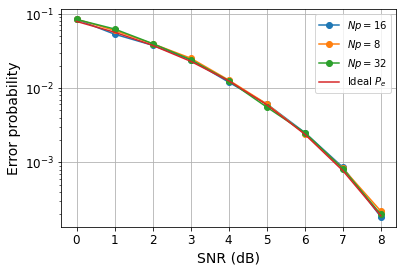

In [62]:
# plot Pe results
for m in range(len(Np_vec)):
    Np = Np_vec[m]
    plt.semilogy(SNR_dB, Pe[m,:], '-o', label="$Np={:2d}$".format(Np))

plt.semilogy(SNR_dB, Q(np.sqrt(2*10**(SNR_dB/10))), label='Ideal $P_e$')

plt.grid()
plt.xlabel('SNR (dB)')
plt.ylabel('Error probability')
plt.legend()

plt.show()

There is very little difference between the three preamble lengths in terms of the resulting error rates. 

Let's dig a little deeper and look at the mean-squared estimation error (MSE), i.e., the average squared difference between the true complex amplitude $X$ and its estimate $\hat{X}$.

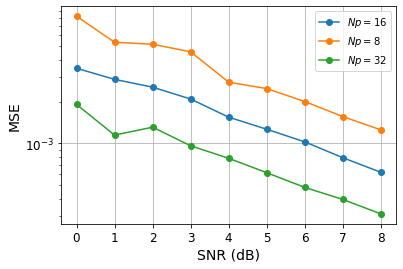

In [63]:
# plot MSE
for m in range(len(Np_vec)):
    Np = Np_vec[m]
    plt.semilogy(SNR_dB, X_hat_mse[m,:], '-o', label="$Np={:2d}$".format(Np))


plt.grid()
plt.xlabel('SNR (dB)')
plt.ylabel('MSE')
plt.legend()

plt.show()

The MSE plot revelas that there are differences between the preamble lengths. Doubling the preamble length reduces the MSE by a factor of 2 for the same SNR. So, why don't these differences translate into different error rates.

At very low SNR, the noise is so large that it dwarfs the relatively small estimation errors. At high SNR, the estimates are quite good even for the short preambles. 

Moreover, the BPSK modulation used in this example is very robust. It is likely that a higher-order modulation is more sensitive to estimations error.